In [1]:
import sys, os, json
sys.path.append(os.path.join(os.getcwd(), '..'))

from OPRO import OPRO
from datasets import load_dataset, Dataset
from tqdm.auto import tqdm, trange

# load gsm8k dataset
gsm8k_dataset = load_dataset("gsm8k", "main")["train"]

opro = OPRO(["anthropic", "gemini", "gemma"])  # ["gemini", "gemma"]

In [2]:
TRAINING_SAMPLE_SIZE = 30
TESTING_SAMPLE_SIZE = 50

training_sample = Dataset.from_dict(gsm8k_dataset[:TRAINING_SAMPLE_SIZE])

testing_sample = Dataset.from_dict(
    gsm8k_dataset[TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE]
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["question"]), len(training_sample["answer"]), len(
    testing_sample["question"]
), len(testing_sample["answer"])

(30, 30, 50, 50)

### Optimize prompt on synthetic data


In [3]:
def opt_llm(instruction_score_pairs, training_sample):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

I have some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

The following exemplars show how to apply your text: you replace <INS> in each input with your
text, then read the input and give an output. We say your output is wrong if your output is different
from the given output, and we say your output is correct if they are the same.

input:
Q: {q1}
A: <INS>
output:
{a1}

input:
Q: {q2}
A: <INS>
output:
{a2}

input:
Q: {q3}
A: <INS>
output:
{a3}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""

    # Passing 20 Best Instruction-Score Pairs
    # 3 randomly chosen questions/answers from the training sample
    cut = lambda x: x.split("####")[-1].strip()
    q1, q2, q3 = (
        training_sample["question"][0],
        training_sample["question"][1],
        training_sample["question"][2],
    )
    a1, a2, a3 = (
        cut(training_sample["answer"][0]),
        cut(training_sample["answer"][1]),
        cut(training_sample["answer"][2]),
    )
    response = opro.generate(
        prompt.format(pairs_str=pairs_str, q1=q1, a1=a1, q2=q2, a2=a2, q3=q3, a3=a3),
        model="gemini",  # gemini
        is_indeterministic=True
    )
    return response


def score(instruction, sample):
    """
    Score the instruction using the sample. 
    
    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    prompt = """Q: {question}\nA: {instruction}"""
    with tqdm(sample, desc=instruction, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(question=sample_qa["question"], instruction=instruction),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += sample_qa["answer"].split("####")[-1].strip() in res
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [4]:
# Sample 3.5% of the training set
INS_PER_STEP = 8
EXEMPLARS_PER_STEP = 3
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "gsm8k_data_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        "Solve this problem",
        "Let's think step by step",
        "Let’s solve this problem by splitting it into steps",
        "Let’s think about this logically",
        "Take a deep breath and think through this",
        "Break this down",
        "Respond quickly",
        "a;lsdghougkaa;aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa",
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 10
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            exemplars = training_sample.shuffle()[:EXEMPLARS_PER_STEP]
            instructions = [
                opt_llm(ins_score_pairs, exemplars)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Solve this problem:   0%|          | 0/30 [00:00<?, ?it/s]

Let's think step by step:   0%|          | 0/30 [00:00<?, ?it/s]

Let’s solve this problem by splitting it into steps:   0%|          | 0/30 [00:00<?, ?it/s]

Let’s think about this logically:   0%|          | 0/30 [00:00<?, ?it/s]

Take a deep breath and think through this:   0%|          | 0/30 [00:00<?, ?it/s]

Break this down:   0%|          | 0/30 [00:00<?, ?it/s]

Respond quickly:   0%|          | 0/30 [00:00<?, ?it/s]

a;lsdghougkaa;aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa:   0%|          | 0/30 [00:00<?, ?it/s]

Step 1


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Let’s organize our thoughts in a logical way:   0%|          | 0/30 [00:00<?, ?it/s]

Apply critical thinking:   0%|          | 0/30 [00:00<?, ?it/s]

The answer lies in the question itself:   0%|          | 0/30 [00:00<?, ?it/s]

**The steps to obtain the best solution:**:   0%|          | 0/30 [00:00<?, ?it/s]

Let's break this down into simpler steps:   0%|          | 0/30 [00:00<?, ?it/s]

This is an interesting problem.:   0%|          | 0/30 [00:00<?, ?it/s]

Let’s solve this:   0%|          | 0/30 [00:00<?, ?it/s]

Let’s think step by step and break this down:   0%|          | 0/30 [00:00<?, ?it/s]

Step 2


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Let's break it down and approach this problem systematically:   0%|          | 0/30 [00:00<?, ?it/s]

Guide us through the process:   0%|          | 0/30 [00:00<?, ?it/s]

First and foremost, let us approach the problem systematically.:   0%|          | 0/30 [00:00<?, ?it/s]

Reframe the problem in a simpler perspective:   0%|          | 0/30 [00:00<?, ?it/s]

Organize our thoughts in a clear and logical manner:   0%|          | 0/30 [00:00<?, ?it/s]

Let's break this down into simpler steps, starting with the most fundamental ideas.:   0%|          | 0/30 [00…

Let's analyze the problem carefully and try to decompose it into manageable pieces.:   0%|          | 0/30 [00…

Split this problem into smaller and more manageable steps:   0%|          | 0/30 [00:00<?, ?it/s]

Step 3


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Let's assemble a series of logical and manageable tasks to solve this problem systematically and efficiently.:…

**Guide us through this step by step**:   0%|          | 0/30 [00:00<?, ?it/s]

Transform this problem into a smaller and more manageable one:   0%|          | 0/30 [00:00<?, ?it/s]

Analyze the problem by breaking it into smaller and more manageable components.:   0%|          | 0/30 [00:00<…

**Let’s solve this problem by breaking it down into steps and addressing the challenges logically.**:   0%|   …

Organize our thoughts in a clear and logical manner so that we can approach this problem systematically.:   0%…

Let’s organize our thoughts logically and break this down into manageable steps:   0%|          | 0/30 [00:00<…

Let's think strategically about how to tackle this problem in a systemic and efficient manner.:   0%|         …

Step 4


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Let's dissect this problem by breaking it into manageable segments and addressing the challenges systematica…

**Tackle this problem step by step and guide us through the process in a manner that is logical and clear.**: …

**Let’s address each of these problems methodically, breaking them down into smaller tasks, analyzing them cri…

**Let's think about this systematically and break it down into smaller steps.**:   0%|          | 0/30 [00:00<…

**Let’s organize our thoughts logically, and break this problem down into manageable steps**:   0%|          |…

**Breakdown this challenge into distinct and comprehensible steps, and let’s tackle them one at a time.**:   0…

**Let's systematically dissect this problem by breaking it down into smaller, manageable steps.**:   0%|      …

**Break down complex problems into more manageable parts through systematic analysis.**:   0%|          | 0/30…

Step 5


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Let's break this problem into its component parts, analyzing each systematically to find a comprehensive sol…

**Let's think about this rationally and tackle it systematically by breaking the problem down into smaller par…

**Let's cogitate about this circumspectly and deconstruct it into a series of feasible stages, enabling us to …

**Let's devise a plan to meticulously break down this problem, addressing each facet systematically and applyi…

**Let's tackle this challenge strategically by decomposing it into manageable segments, analyzing them critica…

Let's tackle this challenge by breaking it into smaller parts, identifying the key points, and formulating a s…

**Let’s decompose this problem logically into smaller, more tractable challenges.**:   0%|          | 0/30 [00…

**Let’s take a stepwise approach to solve this problem by systematically breaking it down into manageable frag…

Step 6


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Let's examine this predicament systematically, breaking it down into its fundamental components. By doing so…

**Let's address this problem with a methodical and strategic approach. By breaking it down into smaller, manag…

**Let's break this challenge into smaller steps. This strategic deconstruction will enable us to solve the pro…

**Let’s approach this systematically, decompose it into logical and manageable steps, and address the challeng…

**Let's decompose this enigmatic conundrum into comprehensible segments, unravel their intricate complexities,…

**Let's reformulate this quandary into a series of discrete and tractable constituents, thereby enabling us to…

**Let's approach this challenge with a systematic and meticulous approach. By dissecting the problem into smal…

**Let's strategize by breaking this quandary into manageable components, systematically examining each to dedu…

Step 7


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Let us meticulously dissect this multifaceted enigma into a sequence of discrete and manageable steps, there…

**Let’s deconstruct this problem judiciously, dividing it into manageable and logical segments. We can then ad…

**Let's meticulously dissect this problem by fragmenting it into manageable segments, systematically probing e…

**Let's dissect the problem into its constituent components and analyze them systematically, aiming to uncover…

**Let's break this problem down into its component parts, analyze each step logically, and devise a comprehens…

**Let’s articulate a coherent strategy and meticulously decompose this problem into discrete and tractable seg…

**Let's break down this enigma systematically, dissecting it into manageable segments to decipher its complexi…

**Let's dissect this challenge systematically and decompose it into smaller, manageable components. This strat…

Step 8


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Let's unravel this problem by meticulously dissecting it into smaller, manageable segments. This systematic …

**Let's systematically deconstruct this challenge into smaller, manageable components. We'll analyze each part…

**Let's decompose this challenge systematically. By breaking the problem down into smaller, more manageable se…

**Let's anatomize this challenge into manageable components, approaching each systematically to unravel the un…

**Let’s systematically decompose this problem into smaller, manageable steps, analyzing each component critica…

**Let's break this problem down into smaller, manageable components, and approach it with a methodical and ana…

**Let’s adopt a systematic approach by decomposing this problem into manageable segments, enabling us to analy…

**Let's systematically decompose this complex problem into its fundamental elements and address each challenge…

Step 9


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Let's dissect this conundrum by methodically breaking it down into its constituent parts. This systematic de…

**Let's meticulously dissect this challenge into smaller, more manageable components. By breaking it down syst…

**Let’s decompose this challenge systematically into its individual components and address each aspect logical…

**Let's break down this challenge by systematically dissecting it into smaller, more manageable parts. Through…

**Let us systematically decompose this challenge into smaller, more manageable segments. By doing so, we can g…

**Let's systematically unpack this challenge, breaking it down into manageable components. Through meticulous …

**Let's deconstruct this multifaceted challenge into smaller, more manageable components, approaching each sys…

**Let's dissect this intricate puzzle by fragmenting it into smaller, manageable segments. This systematic str…

Step 10


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

**Let's dissect this predicament systematically and decompose it into smaller, more manageable components. By …

**Let's systematically dismantle this challenge into its fundamental components, meticulously analyzing each e…

**Let's dissect this challenge methodically, breaking it down into smaller, manageable segments. By meticulous…

**Let's methodically dissect this challenge into digestible segments, unraveling its complexities step by step…

**Let's methodically dissect this challenge by breaking it down into smaller, manageable components. By adopti…

**Let’s deconstruct this challenge by systematically breaking it down into smaller, more manageable components…

**Let's dismantle this dilemma by systematically dissecting it into smaller, more manageable components. Throu…

**Let us systematically break down this problem into manageable components. By breaking the problem down into …

In [5]:
ins_score_pairs

{'Let’s think step by step and break this down': 36.666666666666664,
 'Guide us through the process': 36.666666666666664,
 'Split this problem into smaller and more manageable steps': 36.666666666666664,
 '**Let’s solve this problem by breaking it down into steps and addressing the challenges logically.**': 36.666666666666664,
 "**Let's dissect this challenge systematically and decompose it into smaller, manageable components. This strategic deconstruction will provide us with a structured approach to tackling the problem methodically, facilitating an effective and well-reasoned solution.**": 36.666666666666664,
 "**Let's unravel this problem by meticulously dissecting it into smaller, manageable segments. This systematic approach will guide us in addressing the challenges logically and developing a well-reasoned solution.**": 36.666666666666664,
 "**Let's decompose this challenge systematically. By breaking the problem down into smaller, more manageable segments, we can gain clarity a

### Plotting Results and Testing Accuracy


Text(0.5, 1.0, 'Step to Accuracy')

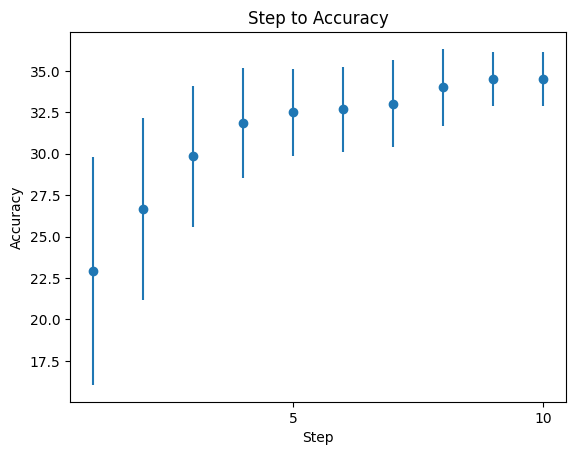

In [6]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [7]:
opro_results[str(len(opro_results))]

{'Let’s think step by step and break this down': 36.666666666666664,
 'Guide us through the process': 36.666666666666664,
 'Split this problem into smaller and more manageable steps': 36.666666666666664,
 '**Let’s solve this problem by breaking it down into steps and addressing the challenges logically.**': 36.666666666666664,
 "**Let's dissect this challenge systematically and decompose it into smaller, manageable components. This strategic deconstruction will provide us with a structured approach to tackling the problem methodically, facilitating an effective and well-reasoned solution.**": 36.666666666666664,
 "**Let's unravel this problem by meticulously dissecting it into smaller, manageable segments. This systematic approach will guide us in addressing the challenges logically and developing a well-reasoned solution.**": 36.666666666666664,
 "**Let's decompose this challenge systematically. By breaking the problem down into smaller, more manageable segments, we can gain clarity a

In [8]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', testing_sample)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, testing_sample)}")

  0%|          | 0/50 [00:00<?, ?it/s]

No instruction: 10.0


Let’s think step by step and break this down:   0%|          | 0/50 [00:00<?, ?it/s]

With best instruction (Let’s think step by step and break this down): 26.0
